In [8]:
#This code brings in data from the HEKA exported from the analysis file called 'Universal.onl'.
#All traces should have been exported with the notebook selected on as well.

#os is for controlling windows explorer mainly
import os
directory=r'C:\Users\jadse\Desktop\Postdoc\Data\SECCMTesting\240205\\'
os.chdir(directory)
fileName='240205_2.asc'

#plt is for plotting
import matplotlib.pyplot as plt
#for regexp operator stuff
import re
#Making HDF5 files!!
import h5py
import numpy as np
import time
from scipy import signal #for smoothing

st = time.time()
#Separate the entire file into an array that has comma separated values.


with open(directory+fileName, 'r') as f:
    data_raw=[]
    for i in f.readlines():
        data_raw.append(i.split(','))
 
"""
The data is comprised of each line of the HEKA.asc files as a list of items separated by a comma
However, the data is not organized in a way that is convenient for us
Also the values of the measurement are in a weird string format that is not appropriate for data treatment
The data in the HEKA.asc is organized this way each 
    - Series_X_X: Each series correspond to a bunch of measurement and for mapping it is one coordinate of the map
        - Sweeps from measurement: Each sweeps contains the data from the measurement and is usually comprised of 5 columns (index, time, I, time, E)
                                    you can have multiple sweeps per series for example OCP and the then LSV
        - Notebook information: Additionnal data from HEKA that give us information from the experiment
                                    There is only one entry of the notebook per serie and it is always the last element of the serie
        
To organize the data we will read trhough the data variable line per line
and based on the values read of the first item of the line we can determine what kind of information is stored in the line

We are reading the first item of the data line so it will be data[0] or n[0] in this case
We identify using the command re.search which looks for a cluster of character in a list of string

    - If it's a serie -> you can identify using "Serie"
    - If it's a sweep -> you can identify using "Sweep_"
    - If it's a notebook entry -> you can identify using "sweep #"
    - A data entry for a measurement -> you can identify using " "

However both the sweep and notebook data entry have " " as an identifier so we need an additional identifier
To do we add a tracker 'sweep_tracker' and 'meta_tracker'
They start at 0 to indicate that they are inactive
If we identify a sweep it will also trigger the change to make sweep_tracker active and notebook_tracker inactive
Conversely, if we identify a notebook it will also trigger the change to make sweep_tracker inactive and notebook_tracker active

Based on these identifier and tracker we can make an algorithm that will place the data in a list of list that have the data conveniently placed in the following order

Level 1 -> Master list: each element is a serie
 level 2 -> Serie list: each element is a sweep
     level 3 -> Sweep list: each element the data form a measurement
         level 4 -> Column: each element consist of the type of the attribute of the measurement (potential, time, current, ...) 
"""
data=[] #Permanent storage for organized data from the HEKA files to be eventually exported
data_header=[]
data_serie=[] #Temporary container for storing "series_data" that will be appended to the "master_data" and reset after a serie is completed
data_sweep=[]  #Temporary container for storing "sweep_data" that will be appended to the "seies_data" and reset after a serie is completed
data_line=[]

serie=[]
test=[]
notebook=[]
notebook_line=[]
notebook_header=[] #Permanent storage of notebook header to identify notebook data
notebook_sweep=[]

sweep_tracker=0 #Tracker for storing a data entry in the "sweep_data"
notebook_tracker=0 #Tracker for storing a data entry in the "notebook_data"

for n in data_raw: #Going through the HEKA file stored in data line per line

#Identifying a sweep header means two thing we just started a new serie or we ended a sweep and start a new sweep         
    if re.search('Sweep_', n[0]): 
        sweep_tracker=1 #If we identify a "Sweep" then we activate the "sweep_tracker"
        notebook_tracker=0
        if len(data_sweep)>0: #If we just started the serie then sweep_data is empty then len(sweep_data=0)
            data_serie.append(data_sweep) #If len(sweep_data)>0 it means we ended a sweep and starting a new one so we need to append the sweep data to the serie
            data_sweep=[] #Additionnaly we need to clean up the sweep_data for the next sweep 
    if re.search('Sweep #', n[0]):
        if len(notebook_header)<1:
            notebook_header.append(n)
 
#Identifying a " " means a data entry from a sweep or the notebook 
    if re.search(' ', n[0][0]):
        if sweep_tracker==1: # if its a sweep then we append to 'sweep_data'
            for element in n:
                data_line.append(float(element))
            
            data_sweep.append(data_line)
            data_line=[]
                               
        if notebook_tracker==1: # if its a notebook then we append to 'notebook_data'
            for element in n[:-1]:
                
                if element[-1]=="m":
                    notebook_line.append(float(element[:-1])*1e-3)
                if element[-1]=="µ":
                    notebook_line.append(float(element[:-2])*1e-6)
                if element[-1]=="n":
                    notebook_line.append(float(element[:-1])*1e-9)
                if re.search("[0-9]", element[-1]):
                    notebook_line.append(float(element))
                if re.search("NAN", element):
                    notebook_line.append("14114")           
            
            if n[-1][-2]=="m":
                notebook_line.append(float(n[-1][:-2])*1e-3)
            if n[-1][-2]=="µ":
                notebook_line.append(float(n[-1][:-3])*1e-6)
            if n[-1][-2]=="n":
                notebook_line.append(float(n[-1][:-2])*1e-9)  
            if re.search("[0-9]", n[-1][-2]):
                notebook_line.append(float(n[-1][:-1]))
            if re.search("NAN", n[-1]):
                notebook_line.append("14114")
                
            notebook_sweep.append(notebook_line)
            notebook_line=[]
            
    if re.search('Serie', n[0]): 
        serie.append(n[0])
    
# Identifying a line skip (\n) as the first element always mean end of a sweep and the start of a new sweep           
    if re.search('\n', n[0]):
        
        if len(data_sweep)>0:
            data_serie.append(data_sweep) #Since we are starting the notebook section that means we reached the end of a sweep then we need to append the 'sweep_data' to the 'serie_data'
            data_sweep=[] # Clear out for new sweep   
            sweep_tracker=0 #If we identify a "Sweep" then we activate the "sweep_tracker"
            notebook_tracker=1
                   
        if len(notebook_sweep)>0: # If it's the end of a sweep and the
            data.append(data_serie)
            data_serie=[] # Clear out for new serie
            notebook.append(notebook_sweep)
            notebook_sweep=[]              

X_pos=[]
Y_pos=[]
header_i= {'x':'', 'y':'', 'z':'', 'scanrate':''}
technique= []

for i,j in enumerate(notebook_header[0]):
    if re.search("X-pos", j):
        header_i['x']= i
        
    if re.search("Y-pos", j):
        header_i['y']= i
        
    if re.search("Z-pos", j):
        header_i['z']= i
        
    if re.search("Rate", j):
        header_i['scanrate']= i
    
for m,n in enumerate(notebook):
    
    X_pos.append(np.abs(np.round((n[0][header_i['x']]-notebook[0][0][header_i['x']])*1e6,0)))
    Y_pos.append(np.abs(np.round((n[0][header_i['y']]-notebook[0][0][header_i['y']])*1e6,0)))   

    if n[0][header_i['scanrate']]!= "14114":
        technique.append('Voltametry')
        
    if n[0][header_i['scanrate']]== "14114":
        if len(data[m][0][0])==5:
            technique.append('OCP')
            
        if len(data[m][0][0])==3:
            technique.append('tip move')
        
OCP= []

Tn= len(dict((i, Y_pos.count(i)) for i in technique))      

for i,j in enumerate(data):
        
    if technique[i]== 'OCP':
        OCP.append(j[0][-1][-1])
        
# plt.scatter(X_pos[0:-1:Tn], Y_pos[0:-1:Tn], s=250, c=OCP, cmap='viridis')
# plt.colorbar()

et = time.time()
print(et-st)        

            

        




4.17109227180481


In [10]:
#HEKA ASC notebook file import.
#This takes everything you just created in the cell above and adds it to the master HDF5 file you specify.
#Make sure the file is opened in 'a' mode and not 'w' mode. 'w' mode deletes all other HDF5 entries.

import h5py
import random

#Function to check for the hdf5 file being created.

with h5py.File(r'C:\Users\jadse\Desktop\Postdoc\Data\HEKAmaster.hdf5','a') as f:
    
    #Build a framework to eventually put variables in.
    if f.__contains__(fileName): #make sure the filename hasn't already been created
        metaData = f[fileName]
        dataDirectory= f[fileName]['Data']
        notebookDirectory = f[fileName]['Notebook']
    else:
        uniqueID=random.randint(0,1000000)
        metaData = f.create_group(fileName)
        dataDirectory= metaData.create_group('Data')
        notebookDirectory = metaData.create_group('Notebook')
    
    #Store the technique list!
    # techniqueList=technique[0]
    # for iiiiiii in range(1,len(technique)):
    #     techniqueList=techniqueList+','+(technique[iiiiiii])
    # metaData.attrs['Technique list'] = techniqueList
    
    #Metadata storage in the top level
    metaData.attrs['Filename'] = fileName
    metaData.attrs['Date'] = fileName[:-4]
    metaData.attrs['Operator'] = 'Jman'
    metaData.attrs['Technique'] = 'CV'
    metaData.attrs['Project'] = 'Medtronics'
    metaData.attrs['Instrument'] = 'ELP3_Glovebox'
    metaData.attrs['Sample'] = 'Blank'
    metaData.attrs['Sample preparation'] = 'AlPolish0_5micron'
    metaData.attrs['Redox mediator'] = 'None'
    metaData.attrs['Mediator concentration'] = 'NA'
    metaData.attrs['Capillary radius'] = '10'
    metaData.attrs['Reference electrode'] = 'Al/Li'
    metaData.attrs['Approach method'] = '3umpers'
    metaData.attrs['Approach potential'] = '2.0'
    metaData.attrs['Solvent'] = 'propyleneCarbonate'
    #metaData.attrs['AC amplitude'] = 'NA'
    #metaData.attrs['AC frequency'] = 'NA'
    
    #This will get us the column we want from the numpy array called 'data' created earlier.
    def getColumnData(seriesNumber,sweepNumber,columnNumber):
        newList=[]
        for iiii in range(len(data[seriesNumber][sweepNumber])):
            newList.append(data[seriesNumber][sweepNumber][iiii][columnNumber])
        return newList
    
    #Next level is the Data -> Serie 1 and Notebook -> Serie 1
    for i in range(len(data)): #Series
        if f.__contains__(fileName+'/Data/Serie '+str(i)):
            print('This has already been added but that is ok.')
        else:
            series=dataDirectory.create_group('Serie '+str(i))
            notebookSeries=notebookDirectory.create_group('Serie '+str(i)) #REDUNDANCY!
            for j in range(len(data[i])): #Sweep
                # print(j) #good for troubleshooting
                for k in range(len(data[i][j][0])): #Columns
                    series.create_dataset('Sweep'+str(j)+'Column'+str(k),data=getColumnData(i,j,k))
                for l in range(len(notebook[i][j])): #Notebook placements, I suppose just like columns.
                    series.attrs[notebook_header[0][l].strip()+str(j)] = notebook[i][j][l]
                    notebookSeries.attrs[notebook_header[0][l].strip()+str(j)] = notebook[i][j][l] #REDUNDANCY!
                if technique:
                    series.attrs['Technique'] = technique[i]
                    notebookSeries.attrs['Technique'] = technique[i] #REDUNDANCY
                
#This is how you can read data:
#with h5py.File(r'C:\Users\jadse\Desktop\Postdoc\Data\HEKAmaster.hdf5','r') as f:
    #print(f[fileName]['Data']['Serie 1']['Sweep3Column4'][:])
    #print('The Filename stored in the hdf5 file is: '+f[str(uniqueID)].attrs.get('Filename')+'.')
    #print(f[fileName)].attrs.keys())
    #print(f[fileName]['Data']['Serie 3'].attrs.keys())
    #print(f[fileName]['Notebook']['Serie 3'].attrs.keys())
    #print(f[fileName]['Notebook']['Serie 3'].attrs.get('SweepC0'))
    #print(f[fileName].attrs.get('Technique list').split(','))
    #print(f[fileName].attrs.get('Technique list'))
    #print(f[fileName].attrs.get('Technique list'))
#print(fileName)

This has already been added but that is ok.
This has already been added but that is ok.
This has already been added but that is ok.
This has already been added but that is ok.
This has already been added but that is ok.
This has already been added but that is ok.
This has already been added but that is ok.
This has already been added but that is ok.
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1
2
3
0
0
1
2
3
4
5
6
7
8
0
1
0
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13


C:\Users\jadse\AppData\Local\Temp\ipykernel_6608\3193931878.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


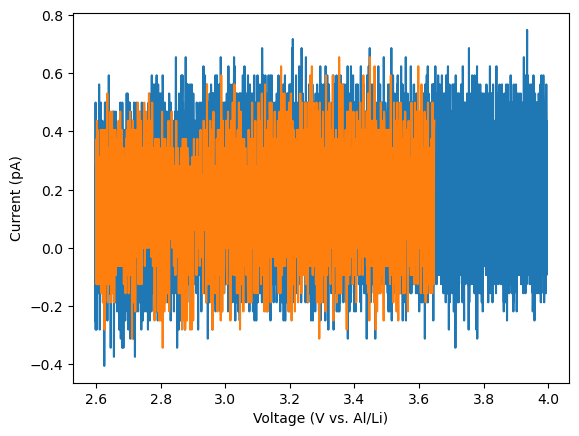

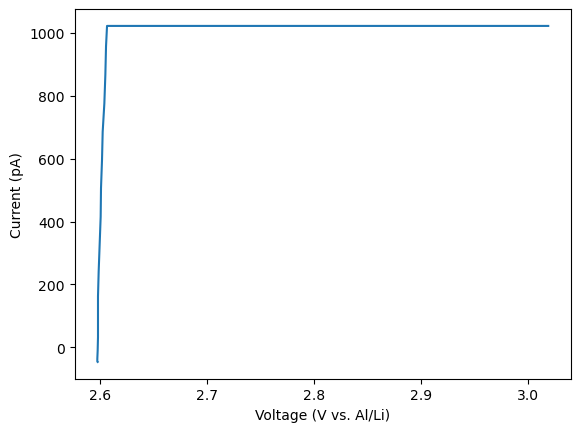

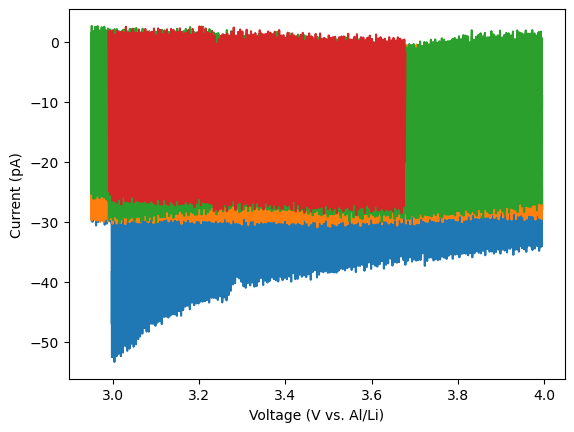

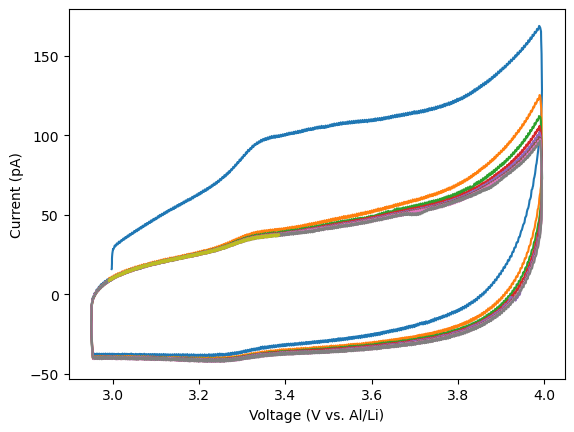

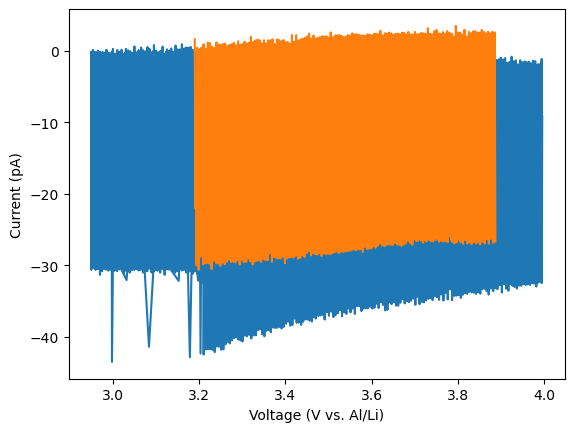

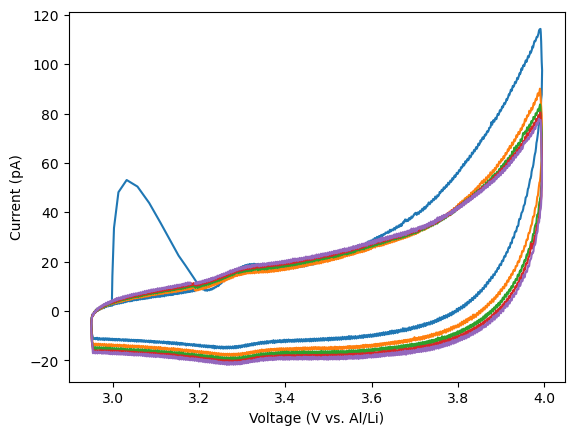

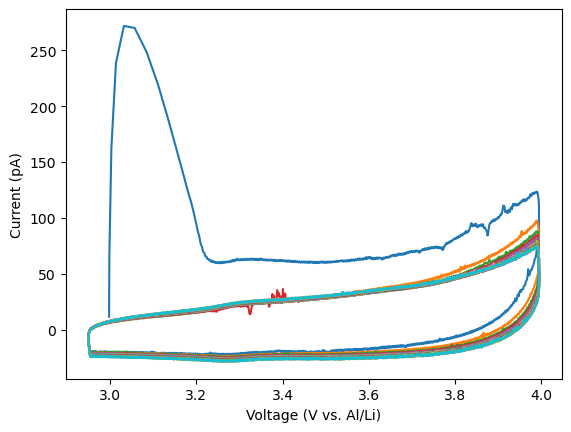

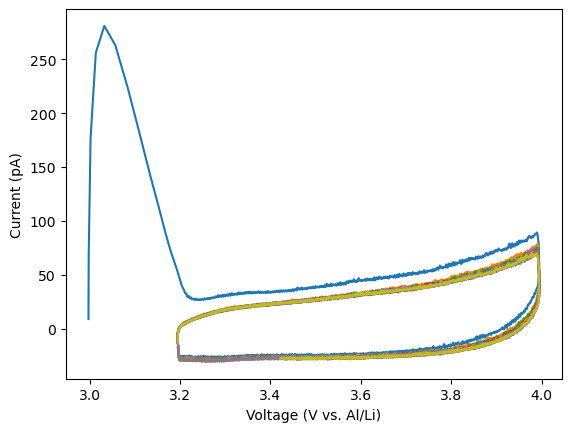

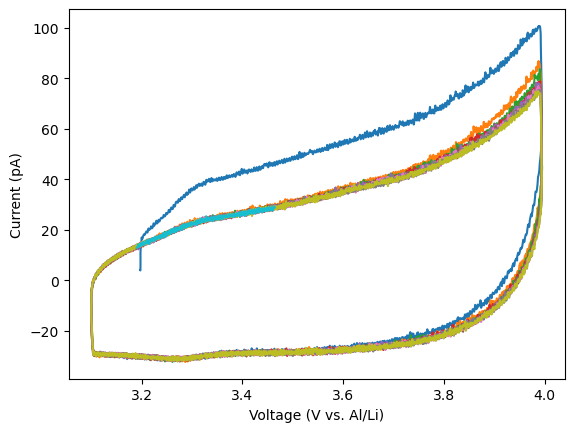

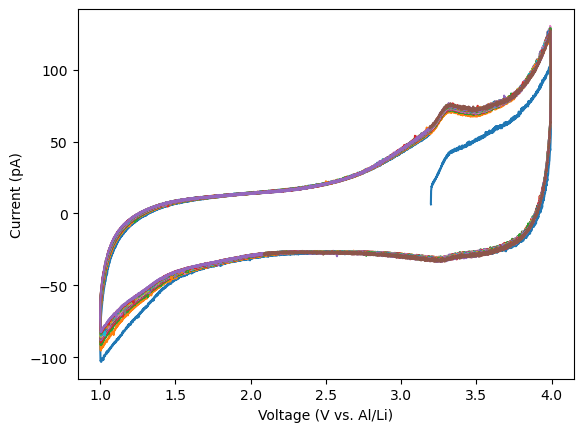

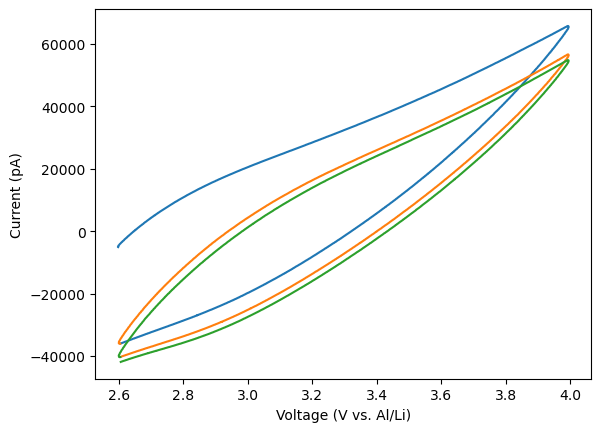

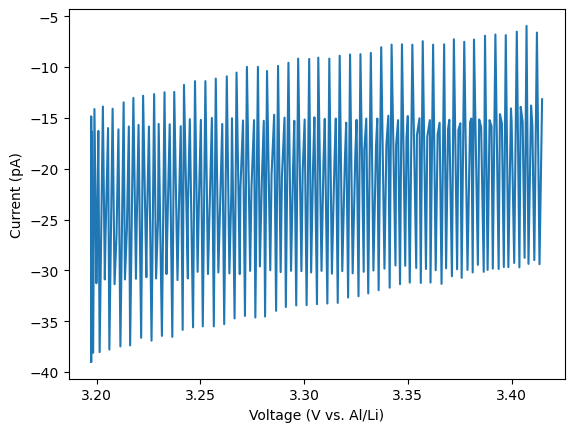

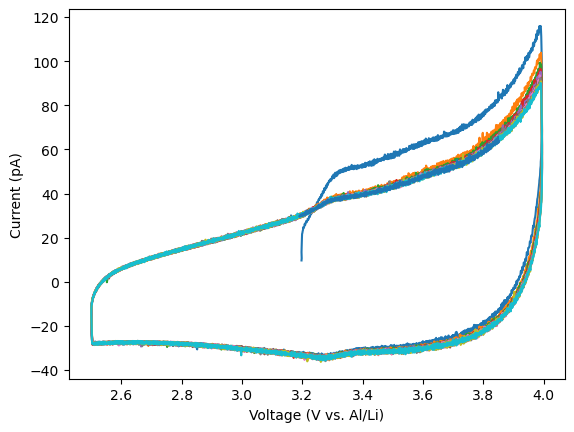

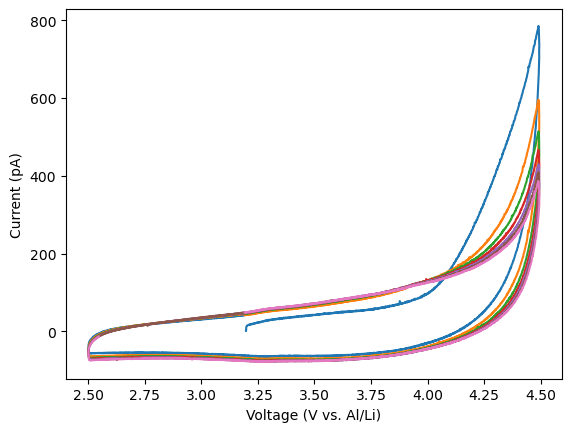

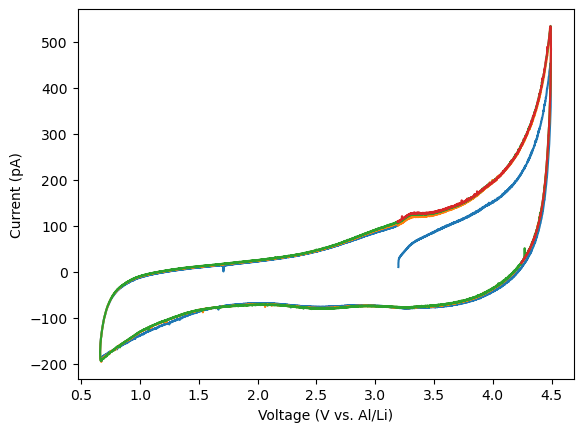

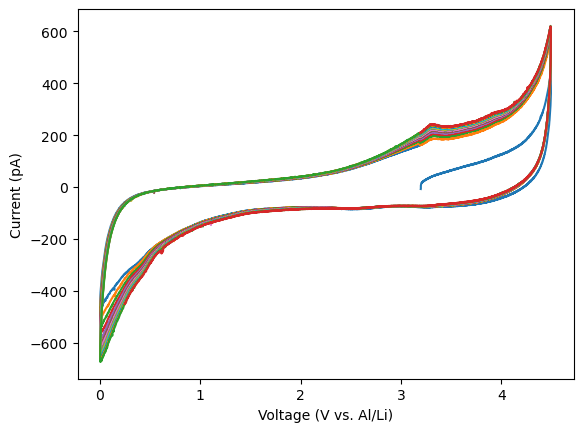

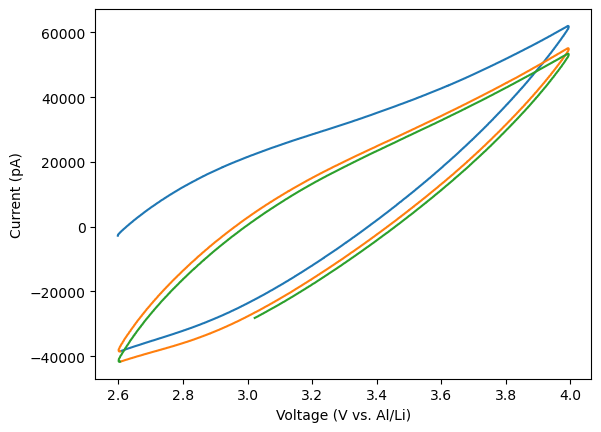

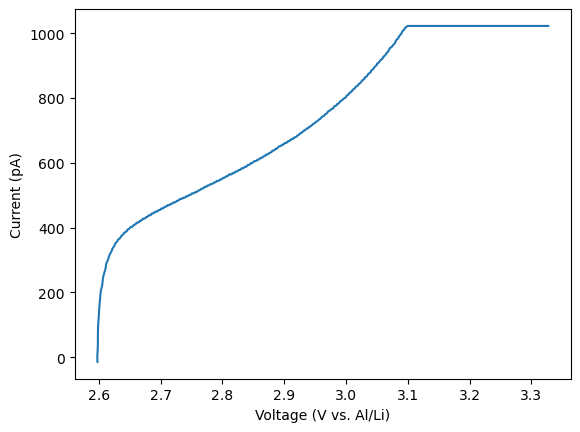

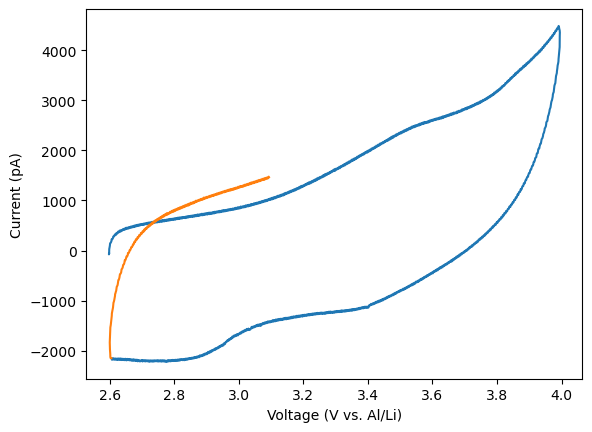

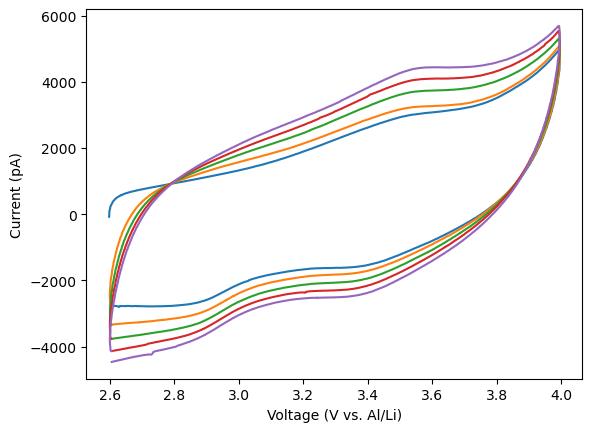

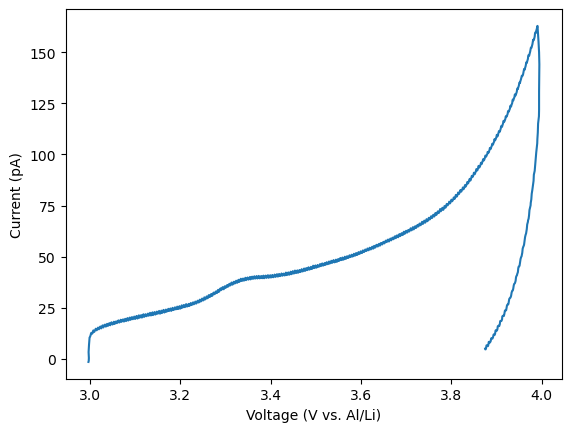

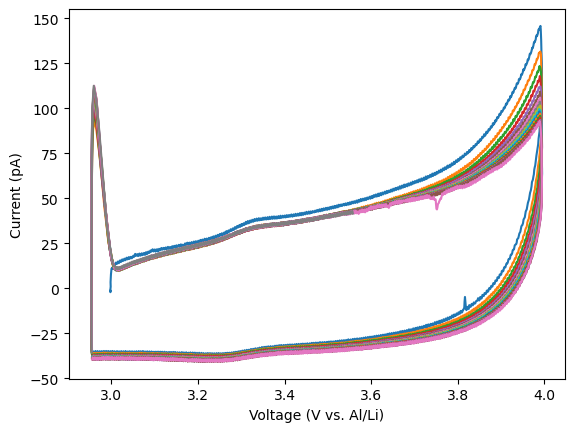

In [11]:
#This plots all of the data from the entry you just inserted above and saves the figures in the directory you specify.

plotSweepsTogether=0 #0 plots series altogether and 1 plots each sweep separately.
plotSmooth=1 #0 gives all plots smoothed and 1 doesn't

xmin=5 #Setting xmin = xmax will result in automatic x limits of a graph.
xmax=5

os.chdir(directory)

#def plotEverything(file,fileName):

with h5py.File(r'C:\Users\jadse\Desktop\Postdoc\Data\HEKAmaster.hdf5','r') as f:
    for series in f[fileName]['Data']: #This iterates through all the series.
        if (len(f[fileName]['Data'][series])%5)%5 == 0: #This filters out tip downs and only gives Series that are multiples of 5's.
            counter=0
            
            #Plotting
            if(plotSweepsTogether == 0):
                
                fig = plt.figure()
                ax = plt.axes()
                ax.set_xlabel('Voltage (V vs. Al/Li)')
                ax.set_ylabel('Current (pA)')
                if xmin != xmax:
                    plt.xlim((xmin, xmax)) 

            while ((counter*5) - len(f[fileName]['Data'][series])) != 0: #Jumps every 5 entries and plots the 5th (potential) vs. the 3rd (current) columns of every sweep.
                if(plotSweepsTogether == 1):
                    fig = plt.figure()
                    ax = plt.axes()
                    ax.set_xlabel('Voltage (V vs. Al/Li)')
                    ax.set_ylabel('Current (pA)')
                    if xmin != xmax:
                        plt.xlim((xmin, xmax)) 
                
                if(plotSmooth==0):
                    smoothY=signal.savgol_filter(f[fileName]['Data'][series]['Sweep'+str(counter)+'Column2'][:],50,3)
                    ax.plot(f[fileName]['Data'][series]['Sweep'+str(counter)+'Column4'][:],smoothY*1e12)
                else:
                    ax.plot(f[fileName]['Data'][series]['Sweep'+str(counter)+'Column4'][:],f[fileName]['Data'][series]['Sweep'+str(counter)+'Column2'][:]*1e12)
                    
                    
                if(plotSweepsTogether == 1):
                    if(plotSmooth==0):
                        plt.savefig(series+'_Sweep'+str(counter)+'_smooth'+".tif")
                    else:
                        plt.savefig(series+'_Sweep'+str(counter)+".tif")
                    
                counter=counter+1
                
            if(plotSweepsTogether == 0):
                if(plotSmooth==0):
                    plt.savefig(series+'_Sweep'+str(counter)+'_smooth'+".tif")
                else:
                    plt.savefig(series+'_Sweep'+str(counter)+".tif")

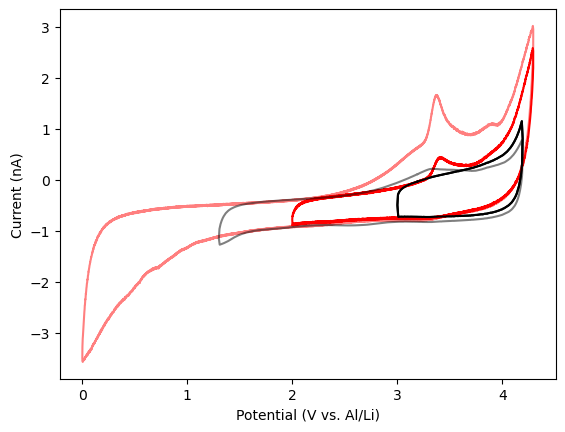

In [23]:
#This is an example of plotting a specific CV from your file.

import h5py
import matplotlib.pyplot as plt
import os
import numpy as np
os.chdir(r'C:\Users\jadse\Desktop\Postdoc\Data\SECCMTesting\240125\\')
file=r'C:\Users\jadse\Desktop\Postdoc\Data\HEKAmaster.hdf5'
fileName='240125.asc'
fileName2='230714.asc'

series=26 # 7 and 13 1 nA, 8 and 14 100 pA, 9 and 12 10 nA, 10 and 11 100 nA
series2=21
sweepNumber=2
sweepNumber2=3

mod=30

with h5py.File(file,'r') as f:
    
    plt.figure()

    plt.plot(f[fileName]['Data']['Serie '+str(series)]['Sweep'+str(sweepNumber)+'Column4'][:]-0.0,f[fileName]['Data']['Serie '+str(series)]['Sweep'+str(sweepNumber)+'Column2'][:]*1e9*3.5-0.3,color='k')
    plt.plot(f[fileName2]['Data']['Serie '+str(series2)]['Sweep'+str(sweepNumber2)+'Column4'][:],f[fileName2]['Data']['Serie '+str(series2)]['Sweep'+str(sweepNumber2)+'Column2'][:]*1e9,color='r')
    plt.plot(f[fileName2]['Data']['Serie '+str(series2+1)]['Sweep'+str(sweepNumber2)+'Column4'][:],f[fileName2]['Data']['Serie '+str(series2+1)]['Sweep'+str(sweepNumber2)+'Column2'][:]*1e9*0.8-0.2,color='r',alpha=0.5)
    plt.plot(f[fileName]['Data']['Serie '+str(series+mod)]['Sweep'+str(sweepNumber)+'Column4'][:]-0.0,f[fileName]['Data']['Serie '+str(series+mod)]['Sweep'+str(sweepNumber)+'Column2'][:]*1e9*2-0.5,color='k',alpha=0.5)

    #Plot it again to emphasize this one CV:
    plt.plot(f[fileName]['Data']['Serie '+str(series)]['Sweep'+str(sweepNumber)+'Column4'][:]-0.0,f[fileName]['Data']['Serie '+str(series)]['Sweep'+str(sweepNumber)+'Column2'][:]*1e9*3.5-0.3,color='k')

    
    plt.ylabel('Current (nA)')
    plt.xlabel('Potential (V vs. Al/Li)')
    #plot 1 and 2
    # plt.legend(['Gently Increasing Potential Window','Aggresively Increasing Potential Window'])
    # plt.savefig('100nACurrentRangeHeaterOnWithWithoutKType.tif')

In [22]:
import h5py

#This is a search function for the database file!
#Notebook information and experimental parameters are stored in different places and must be searched for slightly differently.
#If the search criteria matches the search value, the name of the file containing this match will be added to a list.
#The lists are printed at the end of this code.
searchCriteriaNotebook='Redox mediator'
searchValueNotebook='MPT'

searchCriteriaExperimentalParameter='Rate2[V/s]0'
searchValueExperimentalParameter=0.1



with h5py.File(r'C:\Users\jadse\Desktop\Postdoc\Data\HEKAmaster.hdf5','r') as f:

    #Search program
    searchListNotebook=[]
    searchListExperimentalParameter=[]
    isThisTheFirstScan='yes'
    for i in f:
        
        #This will tell you everything inside the file.
        if isThisTheFirstScan == 'yes':
            print(f.keys()) #The names of files in the .hdf5 file.
            print(f[i].attrs.keys()) #The names of all the possible notebook entries for the first entry.
            print(f[i]['Data']['Serie 0'].attrs.keys()) #The attribute names for all of the experiments for the first entry.
            isThisTheFirstScan = 'no'
        
        #This section searches through notebook entries.
        if f[i].attrs.get(searchCriteriaNotebook) == searchValueNotebook:
            searchListNotebook.append(i)
            
        #This section searches through experimental parameters.
        for j in f[i]['Data']:
            if f[i]['Data'][j].attrs.get(searchCriteriaExperimentalParameter) == searchValueExperimentalParameter:
                if searchListExperimentalParameter.__contains__(i) == 0:
                    searchListExperimentalParameter.append(i)
                    
#Did we get anything?
print()
print('The '+searchCriteriaNotebook+': '+searchValueNotebook+', was found in the following database entries:')
print(searchListNotebook)
print()
print('The '+searchCriteriaExperimentalParameter+': '+str(searchValueExperimentalParameter)+', was found in the following database entries:')
#Sometimes the entry is a string and you will need to use the line below instead of the line above.
# print('The '+searchCriteriaExperimentalParameter+': '+(searchValueExperimentalParameter)+' was found in the following database entries:') 
print(searchListExperimentalParameter)

<KeysViewHDF5 ['230714.asc', '230925.asc', '230928.asc', '231016.asc', '231102.asc', '231103.asc', '231121.asc', '231219.asc', '240105.asc', '240110.asc', '240125.asc', '240205.asc', '240205_2.asc', 'heaterTesting.asc']>
<KeysViewHDF5 ['Approach method', 'Approach potential', 'Capillary radius', 'Date', 'Filename', 'Instrument', 'Mediator concentration', 'Operator', 'Project', 'Redox mediator', 'Reference electrode', 'Sample', 'Sample preparation', 'Solvent', 'Technique']>
<KeysViewHDF5 ['Delta-E-peak0', 'E-Peak_a[V]0', 'E-Peak_c[V]0', 'Extr[A]0', 'I-Peak_a[A]0', 'I-Peak_c[A]0', 'Sweep #0', 'X-pos[m]0', 'Y-pos[m]0', 'Z-height[m]0']>

The Redox mediator: MPT, was found in the following database entries:
['230928.asc', '231016.asc', '231102.asc']

The Rate2[V/s]0: 0.1, was found in the following database entries:
['231016.asc', '231102.asc', '231121.asc', '231219.asc', '240105.asc', '240110.asc', '240125.asc', '240205.asc', '240205_2.asc']
